In [1]:
import transformers as hug
import tensorflow as tf
import pandas as pd
import warnings

from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)


2024-02-06 17:39:38.139748: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 17:39:38.177836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:39:38.177881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:39:38.177927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 17:39:38.191782: I tensorflow/core/platform/cpu_feature_g

In [2]:
tf.config.list_physical_devices('GPU') 

2024-02-06 17:39:41.004563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:39:41.008108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:39:41.008132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
%matplotlib inline
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [4]:
def pre_process_input_data(filepath='./data/concept_net/tweets.csv',encoding='cp1252'): #Change encoding if not on windows
    tweets = pd.read_csv(filepath,encoding=encoding,header=None)
    tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
    tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory

    tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
    return tweets

<Axes: >

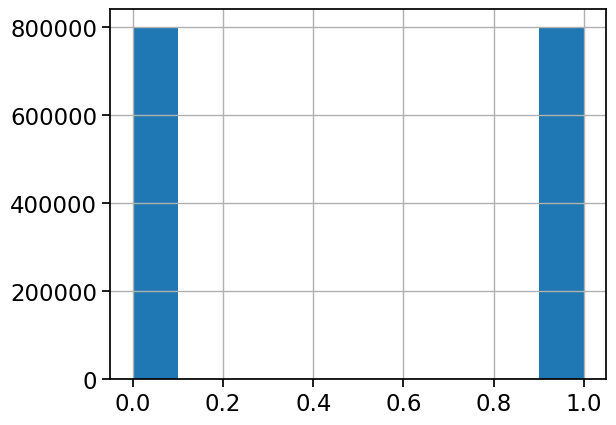

In [5]:
input_data = pre_process_input_data(filepath= "../../data/concept_net/tweets.csv") #Change this to the filepath of the tweets file

input_data['target'].hist()
# input_data.visualize()

## HuggingFace Transformers
<hr>

In [6]:
from transformers import BertTokenizer, TFBertModel
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')
MODEL = TFBertModel.from_pretrained("bert-base-uncased")



2024-02-06 17:42:51.761400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:42:51.761453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:42:51.761462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:42:51.910414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:42:51.910455: I tensorflow/compile

<Axes: >

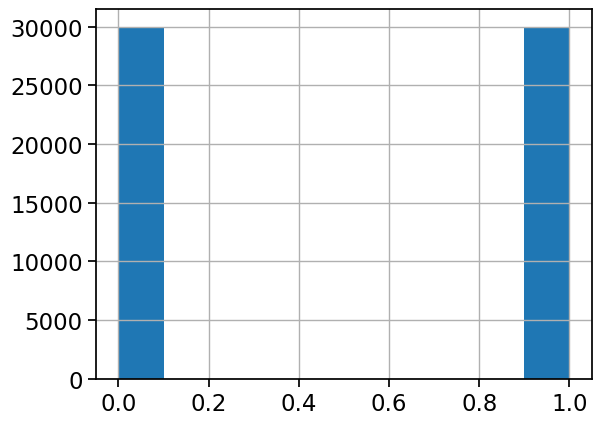

In [7]:
num_samples = 30000
subset = input_data.iloc[:num_samples]
subset = pd.concat([subset,input_data.iloc[-1 * num_samples:]])

# subset = input_data

subset['target'].hist()

In [9]:
# tens,attention = convert_to_encoded("Hello World I am")
def convert_df_to_encoded(df,text_col='text',model=MODEL,tokenizer=TOKENIZER,batch_size=500):

    batches = [(i,min(i+batch_size,len(df))) for i in range(0,len(df),batch_size)] #Split into smaller chunks
    _df = pd.DataFrame()
    max_twt_len = np.max([len(v) for v in df[text_col]])
    print(max_twt_len)
    for lower,upper in tqdm(batches):
        chunk = df.iloc[lower:upper]
        features = tokenizer(chunk[text_col].values.tolist(),padding='max_length', truncation=True, return_tensors='tf',max_length=max_twt_len)
        features = model(**features).last_hidden_state[:,0,:]
        chunk['features'] = features.numpy().tolist()
        _df = pd.concat([_df,chunk])
    return _df
#TODO: PCA compression on vectors down to 250 space for memory reasons


# input_data.sort_values(by='target')

tmp = convert_df_to_encoded(subset)
# tmp = input_data['text'].apply(convert_to_encoded)

359


  0%|          | 0/120 [00:00<?, ?it/s]

#### PCA


In [10]:
x = np.array([x for x in tmp['features']])

In [11]:
x.shape

(60000, 768)

In [12]:
from sklearn.model_selection import train_test_split
vectors = x
targets = tmp['target']
labels = tmp['text']

train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [13]:
train_vectors, val_vectors, train_targets, val_targets, train_labels,val_labels = \
    train_test_split(train_vectors,train_targets,train_labels,test_size = 0.2, random_state=0)

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
train_vectors = pca.fit_transform(train_vectors)
val_vectors = pca.transform(val_vectors)
test_vectors = pca.transform(test_vectors)


In [15]:
print(f"""
Train Vector Shape: {train_vectors.shape}
Validation Vector Shape: {val_vectors.shape}
Test Vector Shape: {test_vectors.shape}
"""
     )


Train Vector Shape: (43200, 300)
Validation Vector Shape: (10800, 300)
Test Vector Shape: (6000, 300)



In [16]:
classifier = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)
classifier.fit(train_vectors, train_targets)

SGDClassifier(loss='log_loss', max_iter=500, random_state=0)

In [17]:
accuracy_score(classifier.predict(test_vectors), test_targets)

0.7768333333333334

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [19]:
def generateNetwork():
    model = Sequential()
    model.add(tf.keras.Input(shape=(300,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
    )
    callbacks = []
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
    return model, callbacks
mdl,callbacks = generateNetwork()

In [20]:
mdl.output_shape


(None, 1)

In [21]:
mdl.fit(train_vectors,train_targets,epochs=200,validation_data=(val_vectors,val_targets),callbacks=callbacks)


Epoch 1/200


2024-02-06 17:49:08.043314: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f81782bb050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-06 17:49:08.043352: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-06 17:49:08.047188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-06 17:49:08.056502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-06 17:49:08.108023: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1350/1350 [==============================] - 4s 3ms/step - loss: 0.5070 - accuracy: 0.7525 - val_loss: 0.4593 - val_accuracy: 0.7876
Epoch 2/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4635 - accuracy: 0.7812 - val_loss: 0.4543 - val_accuracy: 0.7874
Epoch 3/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4528 - accuracy: 0.7887 - val_loss: 0.4527 - val_accuracy: 0.7882
Epoch 4/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4460 - accuracy: 0.7926 - val_loss: 0.4502 - val_accuracy: 0.7891
Epoch 5/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4410 - accuracy: 0.7962 - val_loss: 0.4481 - val_accuracy: 0.7919
Epoch 6/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4352 - accuracy: 0.7993 - val_loss: 0.4482 - val_accuracy: 0.7898
Epoch 7/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.4282 - accuracy: 0.8051 - val_loss: 0.4446 - val_accuracy: 0.79

In [22]:
# accuracy_score(mdl.predict(test_vectors),test_targets)
mdl.evaluate(test_vectors,test_targets)

188/188 [==============================] - 0s 2ms/step - loss: 0.4761 - accuracy: 0.7860


[0.476103276014328, 0.7860000133514404]

In [23]:
mdl.metrics_names

['loss', 'accuracy']

In [24]:
res = mdl.predict(test_vectors)

188/188 [==============================] - 0s 1ms/step


In [32]:
viewer = pd.DataFrame({'predict':res.flatten(),'target':test_targets,'sentence':test_labels})

In [37]:
pd.set_option('max_colwidth', 400)
viewer['diff'] = abs(viewer['predict'] - viewer['target'])
viewer.sort_values(by='diff').tail(30)

,predict,target,sentence,diff
1598551,0.012364,1,Currently staring idly into space - Have done no work today!! Im blaming Lauren Rutherford - shame on her!!!,0.987636
24118,0.987875,0,@sitkacreations I wish - at work Such a pretty day for a beach walk after brunch - enjoy your day!,0.987875
27223,0.989152,0,JALISSA! awe! i just read it lol ily,0.989152
20674,0.989648,0,"Happy Sunny Day Everyone, going back to school tomorrow",0.989648
16416,0.989845,0,"Good night, I taught Oleg and Terr the Hoedown Throwdown, hahah, my first two students! Babies&lt;3. Work tomorrow morning",0.989845
1570420,0.009266,1,I dont know where YOUR at but its raining where im at,0.990734
1587713,0.008543,1,"Haha, I ain't comin' to school tomorrow.",0.991457
1572327,0.008263,1,@camera_obscura_ CRAP!! I forgot to watch! Oh well. It's not like I'm not seeing you guys tomorrow,0.991737
8807,0.994548,0,@theu4life219 cool! thank you thank you,0.994548
1583637,0.005418,1,"@Swanehals no, I'm sorry",0.994582


In [35]:
input_data.iloc[0:30]

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [37]:
input_data.iloc[-30:]

,target,text
1599970,1,Thanks @eastwestchic &amp; @wangyip Thanks! That was just what I was looking for
1599971,1,"@marttn thanks Martin. not the most imaginative interface, but it'll do for now"
1599972,1,@MikeJonesPhoto Congrats Mike Way to go!
1599973,1,http://twitpic.com/7jp4n - OMG! Office Space... I wanna steal it.
1599974,1,"@yrclndstnlvr ahaha nooo you were just away from everyone else! i had to see Kara, she'd die. and yess we aree, ill see you saturday"
1599975,1,"@BizCoachDeb Hey, I'm baack! And, thanks so much for all those kind notes while I was gone. They made me smile at times when I needed it!"
1599976,1,"@mattycus Yeah, my conscience would be clear in that case."
1599977,1,@MayorDorisWolfe Thats my girl - dishing out the &quot;advice&quot;
1599978,1,@shebbs123 i second that
1599979,1,In the garden


In [22]:
#Stolen From Josh SYlvester
# def make_neural_net_no_sentiment():
#     # Create the model
#     model = keras.Sequential([
#         layers.Dense(units=128, activation='relu'),
#         layers.Dense(units=64, activation='relu'),
#         layers.Dense(units=1, activation='sigmoid')
#     ])

#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                                 patience=4, min_lr=0.000001, verbose=1)
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)

#     callbacks = [early_stop, reduce_lr]
#     optimizer = tf.keras.optimizers.Adam(
#         learning_rate=1e-3,
#     )

#     # Compile the model
#     model.compile(optimizer=optimizer,
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])

#     return model, callbacks